In [3]:
# Load data ke dalam data frame 
import pandas as pd

# spesifikasi encoding diperlukan karena data tidak menggunakan UTF-8
df = pd.read_csv('sentimen_200_terpisah.csv', encoding='latin-1') 

df.head()

,review_tokens_stemmed,Sentimen,sentimen,classified_text,tweet_text,sentence_score,max_positive,max_negative,kelas
0,kecewa banget pesan free pouch kirim cotton pa...,Negatif,{'classified_text': 'kecewa [-4] banget pesan ...,kecewa [-4] banget pesan free pouch kirim cott...,kecewa banget pesan free pouch kirim cotton p...,['kecewa [-4] banget pesan free pouch kirim co...,5,-4,positif
1,kali emas tidak safe seperti tutup botol tidak...,Negatif,{'classified_text': 'kali emas [5] tidak safe ...,kali emas [5] tidak safe seperti [1] tutup bot...,kali emas tidak safe seperti tutup botol tida...,['kali emas [5] tidak safe seperti [1] tutup b...,5,-3,positif
2,paket datang barang pecah return seller ikut k...,Negatif,{'classified_text': 'paket datang barang pecah...,paket datang barang pecah [-2] return seller i...,paket datang barang pecah return seller ikut ...,['paket datang barang pecah [-2] return seller...,1,-1,netral
3,enggak sabun nya enggak sesuai deskripsi,Negatif,{'classified_text': 'enggak sabun nya enggak s...,enggak sabun nya enggak sesuai [3] deskripsi,enggak sabun nya enggak sesuai deskripsi,['enggak sabun nya enggak sesuai [3] deskripsi'],3,-1,positif
4,enggak sesuai harap,Negatif,"{'classified_text': 'enggak sesuai [3] harap',...",enggak sesuai [3] harap,enggak sesuai harap,['enggak sesuai [3] harap'],3,-1,positif


In [4]:
# Drop 3 kolom terakhir yang tidak digunakan dengan fungsi iloc
df = df.drop(df.iloc[:,1:8], axis=1)

# Cek data teratas
df.head()

,review_tokens_stemmed,kelas
0,kecewa banget pesan free pouch kirim cotton pa...,positif
1,kali emas tidak safe seperti tutup botol tidak...,positif
2,paket datang barang pecah return seller ikut k...,netral
3,enggak sabun nya enggak sesuai deskripsi,positif
4,enggak sesuai harap,positif


In [5]:
# Data untuk rename kolom v1 dan v2
new_cols = {
    'review_tokens_stemmed' : 'Review',
    'kelas' : 'Sentimen'
}

# Rename nama kolom v1 dan v2
df = df.rename(columns=new_cols)

# Cek data teratas
df.head()

,Review,Sentimen
0,kecewa banget pesan free pouch kirim cotton pa...,positif
1,kali emas tidak safe seperti tutup botol tidak...,positif
2,paket datang barang pecah return seller ikut k...,netral
3,enggak sabun nya enggak sesuai deskripsi,positif
4,enggak sesuai harap,positif


In [6]:
# Cek jumlah data per kelas
print(df['Sentimen'].value_counts())
print('\n')

# Cek kelengkapan data
print(df.info())
print('\n')

# Cek statistik deskriptif
print(df.describe())

positif    107
netral      47
negatif     32
Name: Sentimen, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    186 non-null    object
 1   Sentimen  186 non-null    object
dtypes: object(2)
memory usage: 3.0+ KB
None


              Review Sentimen
count            186      186
unique           182        3
top     terima kasih  positif
freq               3      107


In [7]:
# Data untuk label
new_labels = {
    'negatif' : 0,
    'netral' : 1,
    'positif' : 2
}

# Encode label (mengubah label dari spam dan ham menjadi 1 dan 0)
df['Sentimen'] = df['Sentimen'].map(new_labels)

# Cek data teratas
df.head()

,Review,Sentimen
0,kecewa banget pesan free pouch kirim cotton pa...,2
1,kali emas tidak safe seperti tutup botol tidak...,2
2,paket datang barang pecah return seller ikut k...,1
3,enggak sabun nya enggak sesuai deskripsi,2
4,enggak sesuai harap,2


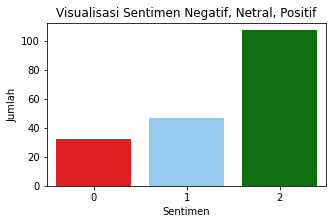

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualisasi sentimen positif, netral, dan negatif
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Sentimen', palette={0: 'red', 1: 'lightskyblue', 2: 'green'})
plt.title('Visualisasi Sentimen Negatif, Netral, Positif')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [9]:
# Memisahkan fitur dengan label
X = df['Review'].values
y = df['Sentimen'].values

In [10]:
# Ekstraksi fitur
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Inisialisasi model
mnb = MultinomialNB()

# Membuat objek StratifiedKFold untuk 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Inisialisasi TfidfVectorizer
bow = TfidfVectorizer(max_features=510)

# List untuk menyimpan prediksi dan label sebenarnya dari setiap lipatan
all_predictions = []
all_true_labels = []

# Loop melalui setiap lipatan (fold) dalam cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]  # Data latih dan uji
    y_train, y_test = y[train_index], y[test_index]  # Label data latih dan uji

    # Transformasi seluruh data menggunakan TfidfVectorizer
    X_train_transform = bow.fit_transform(X_train)
    X_test_transform = bow.transform(X_test)

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transform, y_train)

    # Melatih model klasifikasi pada data latih
    mnb.fit(X_train_resampled, y_train_resampled)

    # Membuat prediksi pada data uji
    predictions = mnb.predict(X_test_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions.extend(predictions)
    all_true_labels.extend(y_test)

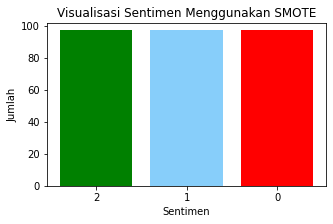

In [11]:
# visualisasi hasil resampling
# Convert NumPy array to pandas Series
y_train_resampled_series = pd.Series(y_train_resampled)

# Visualisasi hasil resampling
sentimen_counts = y_train_resampled_series.value_counts()

plt.figure(figsize=(5, 3))
plt.bar(sentimen_counts.index, sentimen_counts.values, color=['red', 'lightskyblue', 'green'])
plt.title('Visualisasi Sentimen Menggunakan SMOTE')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.xticks(sentimen_counts.index, ['0', '1', '2'])
plt.show()

In [12]:
# Hitung metrik evaluasi
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted')
recall = recall_score(all_true_labels, all_predictions, average='weighted')
f1 = f1_score(all_true_labels, all_predictions, average='weighted')

# Print hasil
print("Overall accuracy:", accuracy)
print("Overall precision:", precision)
print("Overall recall:", recall)
print("Overall F1-score:", f1)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels, all_predictions)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels, all_predictions, zero_division=0))

Overall accuracy: 0.6344086021505376
Overall precision: 0.625651904097001
Overall recall: 0.6344086021505376
Overall F1-score: 0.6246633987055008
Confusion Matrix : 
 [[23  4  5]
 [17 12 18]
 [ 6 18 83]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.50      0.72      0.59        32
           1       0.35      0.26      0.30        47
           2       0.78      0.78      0.78       107

    accuracy                           0.63       186
   macro avg       0.55      0.58      0.56       186
weighted avg       0.63      0.63      0.62       186



In [13]:
new_text = input("\nMasukkan teks baru: ")
new_text_vec = bow.transform([new_text])
predicted_sentimen = mnb.predict(new_text_vec)

if predicted_sentimen[0] == 0:
    sentiment_label = "negatif"
elif predicted_sentimen[0] == 1:
    sentiment_label = "netral"
elif predicted_sentimen[0] == 2:
    sentiment_label = "positif"

print("Hasil Analisis Sentimen untuk Teks Baru : ", sentiment_label)

Hasil Analisis Sentimen untuk Teks Baru :  negatif
